In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from ccsblib import paros_connection
from ccsblib import ccsbplotlib as cplt

from data_loading import (load_isoform_and_paralog_y2h_data, 
                          load_m1h_activation_data,
                          load_y1h_pdi_data,
                          load_valid_isoform_clones,
                          load_ref_vs_alt_isoforms_table)

pd.set_option('display.max_columns', 50)

In [2]:
# G12 and H12 are positive controls 

In [3]:
y2h = load_isoform_and_paralog_y2h_data()
iso_gte_1_pos_ppi_iso_data_only = set(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                          (y2h['Y2H_result'] == True), 'ad_clone_acc'].unique()) 
iso_gte_1_pos_ppi_all_data = set(y2h.loc[(y2h['Y2H_result'] == True), 'ad_clone_acc'].unique())
# restict to TF isoform data (i.e. not paralogs etc.)
ppi = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'), 
              ['category',
               'ad_clone_acc',
               'ad_gene_symbol',
               'db_gene_symbol',
               'Y2H_result']].copy()
# at least one positive per PPI partner
ppi = ppi.loc[ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])
                 ['Y2H_result']
                 .transform(lambda row: (row == True).any()),
              :]
# at least one successfully tested PPI per isoform
ppi = ppi.loc[ppi.groupby('ad_clone_acc')
                  ['Y2H_result']
                  .transform(lambda x: (x.notnull().any())),
              :]
# at least two partners per isoform
ppi = ppi.loc[ppi.groupby('ad_gene_symbol')
                 ['ad_clone_acc']
                 .transform(lambda x: x.nunique() >= 2),
              :]
y1h = load_y1h_pdi_data()
m1h = load_m1h_activation_data()
# rna = load_rna_expression_data()
isoforms = load_valid_isoform_clones()
iso_pairs = load_ref_vs_alt_isoforms_table()
iso_pairs['both_iso_y2h_pos'] = (iso_pairs['clone_acc_ref'].isin(iso_gte_1_pos_ppi_iso_data_only) &
                                 iso_pairs['clone_acc_alt'].isin(iso_gte_1_pos_ppi_iso_data_only))
iso_pairs['both_iso_y2h_pos_all_data'] = (iso_pairs['clone_acc_ref'].isin(iso_gte_1_pos_ppi_all_data) &
                                          iso_pairs['clone_acc_alt'].isin(iso_gte_1_pos_ppi_all_data))

In [4]:
iso_pairs.head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,...,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,both_iso_y2h_pos,both_iso_y2h_pos_all_data
0,ZBTB18,ENSG00000179456,C2H2 ZF,False,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,ENST00000358704,ENST00000622512,False,False,True,531,522,2,1,True,False,False,False,True,False,False,False,0.0,0.000000,...,4.0,3.0,4.0,4.0,3.0,3.0,0.75,NaN,loses some,loses some,retains all,retains all,0.0,1.0,1.0,0.0,1.0,0.0,0.000000,True,2.153413,2.656826,0.503414,True,True
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,True,245,217,4,4,False,True,False,False,False,False,False,False,0.0,0.000000,...,0.0,13.0,13.0,0.0,13.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,True,1.552087,0.679816,-0.872271,False,False
2,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|3/3|09H08,ENST00000239461,ENST00000497230,False,False,True,245,200,4,3,False,True,False,True,False,False,False,False,0.0,0.000000,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,9.0,11.0,11.0,9.0,9.0,0.818182,True,1.552087,0.773129,-0.778958,False,False
3,POU2F1,ENSG00000143190,Homeodomain; POU,False,POU2F1|2/2|04D01,POU2F1|1/2|03F12,ENST00000541643,ENST00000367862,False,False,False,743,755,15,16,True,False,False,False,True,False,False,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2.509024,NaN,NaN,False,False
4,ATF3,ENSG00000162772,bZIP,True,ATF3|1/2|08B04,ATF3|2/2|08D04,ENST00000341491|ENST00000366987,ENST00000366983,False,False,True,181,135,3,3,False,True,False,False,False,False,False,False,19.0,46.774194,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.979226,-0.381163,-1.360389,False,False


In [4]:
clone_to_orf_id = y2h[['ad_clone_acc', 'ad_orf_id']].drop_duplicates().set_index('ad_clone_acc')['ad_orf_id']

In [5]:
non_zero_iso = set(iso_pairs.loc[(iso_pairs['n_PPI_successfully_tested_in_ref_and_alt'] >= 2)
                             & iso_pairs['both_iso_y2h_pos'], ['clone_acc_ref', 'clone_acc_alt']].values.flatten())
non_zero_iso = {clone_to_orf_id[s] for s in non_zero_iso}

In [6]:
#TEMP DEBUG
y2h = load_isoform_and_paralog_y2h_data()

In [7]:
qry = """SELECT a.test_orf_ida,
	   a.test_orf_idb,
	   b.iso_orf_id,
	   b.huri_orf_id,
	   b.source,
	   a.call_1_percent_RRS AS result,
	   a.final_score,
	   c.score,
	   c.empty_n1, c.empty_n2
        FROM tf_validation.validation AS a
        LEFT JOIN tf_validation.validation_source AS b
        ON (a.test_orf_ida = b.orf_id1
        	AND a.test_orf_idb = b.orf_id2)
          OR (a.test_orf_idb = b.orf_id1
        	AND a.test_orf_ida = b.orf_id2)
        LEFT JOIN (select j.score_id, j.score, 
	   						k.empty_n1, k.empty_n2 
							from tf_validation.mn2h_scoring AS j
							left join tf_validation.mn2h_control AS k
							using (plate, well)) AS c
          on a.final_score_id = c.score_id;"""
n2h = pd.read_sql(qry, paros_connection())
n2h['max_control'] = n2h[['empty_n1', 'empty_n2']].max(axis=1)
n2h['non_zero_iso'] = n2h['iso_orf_id'].isin(non_zero_iso)
n_rows_b4 = n2h.shape[0]
n2h = pd.merge(n2h,
         y2h.loc[y2h['category'].isin({'tf_isoform_ppis', 
                                        'tf_paralog_ppis',
                                        'paralog_with_PDI',
                                        'non_paralog_control'}),
				 ['ad_orf_id',
				 'db_orf_id',
				 'ad_gene_symbol',
				 'ad_clone_acc',
				 'db_gene_symbol',
				 'category',
				 'Y2H_result']],
         how='left',
         left_on=['iso_orf_id', 'huri_orf_id'],
         right_on=['ad_orf_id', 'db_orf_id'],
         suffixes=('_n2h', '_y2h'))
if n2h.shape[0] != n_rows_b4:
    raise UserWarning('Problem with table join')

<ipython-input-7-e52f02ddaf67>:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  n2h = pd.read_sql(qry, paros_connection())


In [8]:
tcf4_orf_ids = y2h.loc[y2h['ad_clone_acc'].str.startswith('TCF4'), 'ad_orf_id'].unique()
n2h.loc[(n2h['test_orf_ida'].isin(tcf4_orf_ids) | 
        n2h['test_orf_idb'].isin(tcf4_orf_ids)) &
        (n2h['source'] == 'pos'), 'result'].value_counts()

0.0    16
1.0     4
Name: result, dtype: int64

In [9]:
np.sqrt((0.8*0.2) / 20)

0.0894427190999916

In [10]:
mismatch = (n2h['source'].isin({'pos', 'neg', 'pos-matched-neg'}) & 
               n2h['Y2H_result'].isnull())
mismatch = mismatch | (n2h['source'].isin({'pos'}) & (n2h['Y2H_result'] != True))
mismatch = mismatch | (n2h['source'].isin({'neg', 'pos-matched-neg'}) & (n2h['Y2H_result'] != False))
n2h['mismatch_current_data'] = mismatch
n2h = n2h.loc[~n2h['mismatch_current_data'], :]

In [11]:
n2h = pd.merge(n2h.drop(columns=['category']),
         y2h.loc[:, ['ad_orf_id', 'db_orf_id', 'category', 'Y2H_result']],
         how='left',
         left_on=['iso_orf_id', 'huri_orf_id'],
         right_on=['ad_orf_id', 'db_orf_id'])

In [12]:
n2h.groupby('source')['category'].apply(lambda x: x.isnull().sum())

source
PRSV2                         88
TF_RRS                        80
huri_rrs                     846
isoform_matched_negatives      2
isoform_negatives              2
isoform_positives              2
lit_bm_2013_rand250          424
litbm                         54
neg                            0
pos                            0
pos-matched-neg                0
whole_tf_genes                 0
Name: category, dtype: int64

In [13]:
for source in n2h['source'].unique():
    print(source)
    print(n2h.loc[n2h['source'] == source, 'category'].value_counts())
    print()

lit_bm_2013_rand250
Series([], Name: category, dtype: int64)

litbm
lit_bm_isoforms    180
tf_isoform_ppis     48
Name: category, dtype: int64

huri_rrs
Series([], Name: category, dtype: int64)

pos-matched-neg
tf_isoform_ppis        45
tf_paralog_ppis         5
non_paralog_control     3
Name: category, dtype: int64

pos
tf_isoform_ppis        75
tf_paralog_ppis         6
non_paralog_control     1
Name: category, dtype: int64

isoform_positives
tf_isoform_ppis    180
Name: category, dtype: int64

neg
tf_paralog_ppis        31
tf_isoform_ppis        26
non_paralog_control    14
Name: category, dtype: int64

TF_RRS
rrs_isoforms       242
tf_isoform_ppis      8
Name: category, dtype: int64

isoform_matched_negatives
tf_isoform_ppis    101
Name: category, dtype: int64

isoform_negatives
tf_isoform_ppis    98
Name: category, dtype: int64

whole_tf_genes
tf_isoform_ppis    72
Name: category, dtype: int64

None
Series([], Name: category, dtype: int64)

PRSV2
Series([], Name: category, dtype: 

In [14]:
for source in n2h['source'].unique():
    print(source)
    print(n2h.loc[n2h['source'] == source, 'score'].value_counts())
    print()

lit_bm_2013_rand250
13.0     14
17.0     14
15.0     12
18.0     10
21.0      8
         ..
278.0     2
56.0      2
137.0     2
87.0      2
43.0      2
Name: score, Length: 86, dtype: int64

litbm
17.0      8
16.0      6
38.0      4
11.0      4
35.0      4
         ..
129.0     2
780.0     2
1109.0    2
1810.0    2
241.0     2
Name: score, Length: 66, dtype: int64

huri_rrs
13.0      34
16.0      28
19.0      22
21.0      20
15.0      20
          ..
178.0      2
711.0      2
1699.0     2
127.0      2
129.0      2
Name: score, Length: 112, dtype: int64

pos-matched-neg
21.0       4
29.0       3
44.0       2
15.0       2
589.0      1
233.0      1
189.0      1
68.0       1
297.0      1
57.0       1
396.0      1
98.0       1
526.0      1
2669.0     1
1604.0     1
40.0       1
46.0       1
192.0      1
5437.0     1
446.0      1
24.0       1
654.0      1
13.0       1
11.0       1
101.0      1
11268.0    1
33.0       1
25.0       1
110.0      1
129.0      1
16.0       1
23.0       1
199.0   

In [15]:
n2h.groupby('source')['non_zero_iso'].value_counts()

source                     non_zero_iso
PRSV2                      False            88
TF_RRS                     False           262
                           True             68
huri_rrs                   False           846
isoform_matched_negatives  True             99
                           False             4
isoform_negatives          True             97
                           False             3
isoform_positives          True            179
                           False             3
lit_bm_2013_rand250        False           424
litbm                      False           178
                           True            104
neg                        True             47
                           False            24
pos                        True             74
                           False             8
pos-matched-neg            True             33
                           False            20
whole_tf_genes             True             51
                    

In [16]:
n2h['source'].unique()

array(['lit_bm_2013_rand250', 'litbm', 'huri_rrs', 'pos-matched-neg',
       'pos', 'isoform_positives', 'neg', 'TF_RRS',
       'isoform_matched_negatives', 'isoform_negatives', 'whole_tf_genes',
       None, 'PRSV2'], dtype=object)

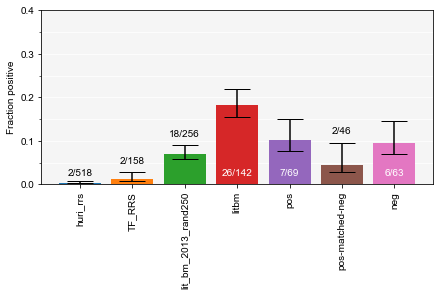

In [17]:
sources = ['huri_rrs', 'TF_RRS', 'lit_bm_2013_rand250', 'litbm',
           'pos', 'pos-matched-neg', 'neg']
cplt.validation_plot(data=n2h,
                     selections=[n2h['source'] == s for s in sources],
                     labels=sources,
                     y_max=0.4,
                    xlabel_rotation=90,
                     errorbar_capsize=0.1)
plt.show()

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/ccsblib/ccsbplotlib/validation.py:146: RuntimeWarning: invalid value encountered in divide
  fracs = pos / tested


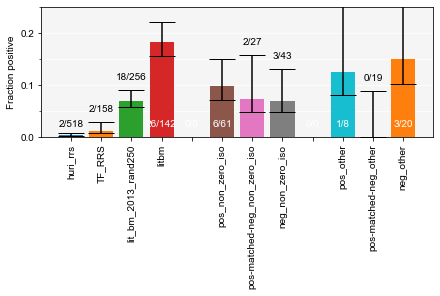

In [18]:
samples = {'huri_rrs': n2h['source'] == 'huri_rrs',
           'TF_RRS': n2h['source'] == 'TF_RRS',
           'lit_bm_2013_rand250': n2h['source'] == 'lit_bm_2013_rand250',
           'litbm': n2h['source'] == 'litbm',
           '': pd.Series(index=n2h.index, data=False),
           'pos_non_zero_iso': (n2h['source'] == 'pos') &
                               n2h['non_zero_iso'],
           'pos-matched-neg_non_zero_iso': (n2h['source'] == 'pos-matched-neg') & n2h['non_zero_iso'],
            'neg_non_zero_iso': (n2h['source'] == 'neg') & n2h['non_zero_iso'],
            ' ': pd.Series(index=n2h.index, data=False),
           'pos_other': (n2h['source'] == 'pos') & ~n2h['non_zero_iso'],
           'pos-matched-neg_other': (n2h['source'] == 'pos-matched-neg') & ~n2h['non_zero_iso'],
           'neg_other': (n2h['source'] == 'neg') & ~n2h['non_zero_iso']}

cplt.validation_plot(data=n2h,
                     selections=list(samples.values()),
                     labels=list(samples.keys()),
                     y_max=0.25,
                    xlabel_rotation=90,
                     errorbar_capsize=0.1)
plt.savefig('../figures/N2H_non_zero_isoforms.pdf', bbox_inches='tight')
plt.show()

In [19]:
n2h.columns

Index(['test_orf_ida', 'test_orf_idb', 'iso_orf_id', 'huri_orf_id', 'source',
       'result', 'final_score', 'score', 'empty_n1', 'empty_n2', 'max_control',
       'non_zero_iso', 'ad_orf_id_x', 'db_orf_id_x', 'ad_gene_symbol',
       'ad_clone_acc', 'db_gene_symbol', 'Y2H_result_x',
       'mismatch_current_data', 'ad_orf_id_y', 'db_orf_id_y', 'category',
       'Y2H_result_y'],
      dtype='object')

In [20]:
(n2h.loc[n2h['source'].isin({'pos', 'neg', 'pos-matched-neg'}) &
        n2h['non_zero_iso'],
        ['ad_gene_symbol', 'ad_clone_acc', 'db_gene_symbol',
         'source', 'category', 'result']]
    .rename(columns={'source': 'N2H_category',
                     'category': 'Y2H_category',
                     'result': 'N2H_result'})
    .sort_values(['N2H_category', 'Y2H_category', 'ad_gene_symbol'])
    .to_csv('../output/N2H_non_zero_iso_only.tsv',
            index=False,
            sep='\t'))

<ipython-input-21-7912894405c0>:16: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.35)


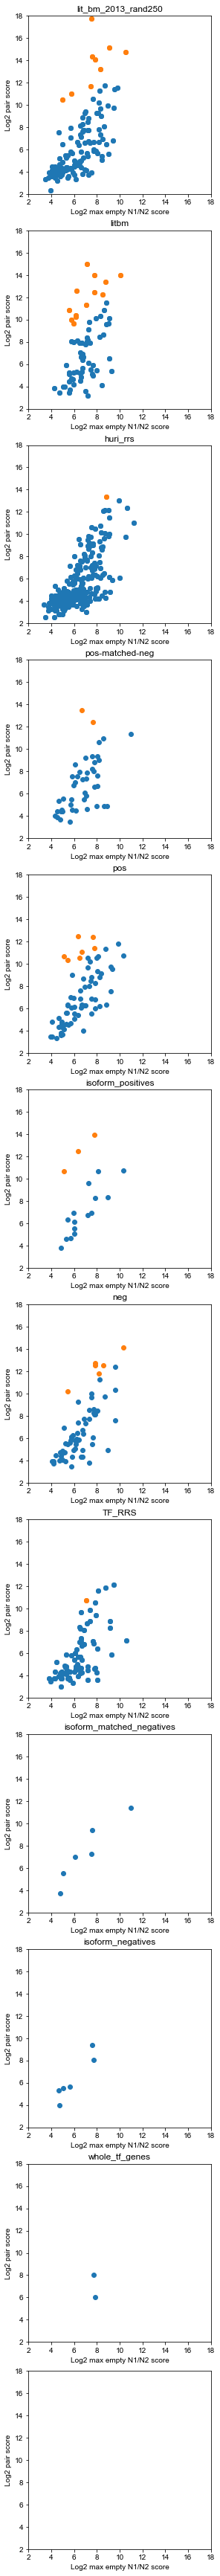

In [21]:
fig, axes = plt.subplots(n2h['source'].nunique())
fig.set_size_inches(4, 4 * axes.shape[0])
for cat, ax in zip(n2h['source'].unique(), axes):
    ax.set_title(cat)
    is_cat = n2h['source'] == cat
    is_pos = n2h['result'] == 1
    is_neg = n2h['result'] == 0
    ax.scatter(x=np.log2(n2h.loc[is_cat & is_neg, 'max_control']),
               y=np.log2(n2h.loc[is_cat & is_neg, 'score']))
    ax.scatter(x=np.log2(n2h.loc[is_cat & is_pos, 'max_control']),
               y=np.log2(n2h.loc[is_cat & is_pos, 'score']))
    ax.set_xlim(2, 18)
    ax.set_ylim(2, 18)
    ax.set_xlabel('Log2 max empty N1/N2 score')
    ax.set_ylabel('Log2 pair score')
plt.subplots_adjust(hspace=0.35)
plt.savefig('../figures/n2h_scatter.pdf', bbox_inches='tight')

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/ccsblib/ccsbplotlib/validation.py:146: RuntimeWarning: invalid value encountered in divide
  fracs = pos / tested


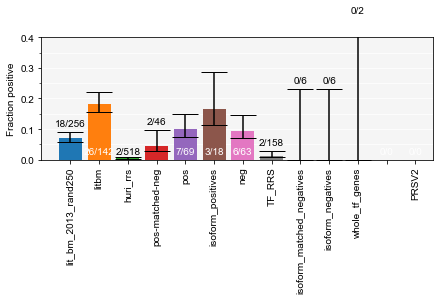

In [22]:
sources = n2h['source'].unique()
cplt.validation_plot(data=n2h,
                     selections=[n2h['source'] == s for s in sources],
                     labels=sources,
                     y_max=0.4,
                    xlabel_rotation=90,
                     errorbar_capsize=0.1)
plt.show()

In [23]:
# did the TF RRS / Lit-BM really take the longest isoforms?
n2h.loc[n2h['source'].isin(['TF_RRS', 'litbm']), 'iso_orf_id'].map(clone_to_orf_id.reset_index().set_index('ad_orf_id')['ad_clone_acc']).unique()

array(['ZBTB16|1/2|01C03', 'TCF4|1/9|07E01', 'ZSCAN9|1/3|11H08',
       'ZNF302|1/5|06F09', nan, 'OSR2|1/2|09C08', 'RXRA|1/3|05C01',
       'PATZ1|1/4|02C02', 'STAT3|1/3|08B06', 'RFX3|2/5|10F10',
       'SALL3|1/2|01B09', 'MLX|1/4|11G02', 'KLF4|1/3|01H05',
       'PPARG|1/4|10G02', 'ZNF174|1/3|02G04', 'TEAD3|1/2|10E03',
       'ZNF212|1/2|12D01', 'MEIS1|1/2|09A04', 'MXD3|1/4|06C09',
       'PAX7|1/4|12G08', 'POU5F1|1/2|11H07', 'MITF|2/4|12H11',
       'HEY1|1/2|04A03', 'ZNF101|1/2|11G06', 'KLF12|1/4|09B08',
       'TGIF1|1/3|02H07', 'PCGF6|1/2|11A10', 'MAX|1/6|08G02',
       'NFE2L2|1/3|12H08', 'SMAD3|1/4|06A07', 'RELA|1/4|04H05',
       'ELF2|1/4|03A11', 'ELF5|1/3|05H09', 'DLX5|1/2|06G01',
       'NFAT5|1/2|02F01', 'ZNF175|1/3|12H06', 'ZBTB18|1/2|04E08',
       'OVOL1|1/2|11D06', 'VDR|1/3|05B02', 'TCF7L2|1/14|05E01',
       'MSX2|1/2|02H09', 'ZNF180|1/4|10E12', 'GRHL3|1/7|08E10',
       'NFIX|1/4|08H03', 'ZNF599|1/4|08F11', 'RBPJ|1/4|01F06',
       'TFCP2|1/3|03E08', 'NR4A1|1/5|03A04'

In [24]:
from data_loading import load_valid_isoform_clones
clones = load_valid_isoform_clones()

In [25]:
clones.loc[clones['gene_symbol'] == 'PAX8', :]

,gene,clone_acc,cds,aa_seq,num_aa,is_novel_isoform,clone_name
330,PAX8,PAX8|1/5|07H05,ATGCCTCACAACTCCATCAGATCTGGCCATGGAGGGCTGAACCAGC...,MPHNSIRSGHGGLNQLGGAFVNGRPLPEVVRQRIVDLAHQGVRPCD...,451,True,PAX8-1
331,PAX8,PAX8|2/5|12F12,ATGCCTCACAACTCCATCAGATCTGGCCATGGAGGGCTGAACCAGC...,MPHNSIRSGHGGLNQLGGAFVNGRPLPEVVRQRIVDLAHQGVRPCD...,450,False,PAX8-2
332,PAX8,PAX8|3/5|07G08,ATGCCTCACAACTCCATCAGATCTGGCCATGGAGGGCTGAACCAGC...,MPHNSIRSGHGGLNQLGGAFVNGRPLPEVVRQRIVDLAHQGVRPCD...,388,True,PAX8-3
333,PAX8,PAX8|4/5|07H07,ATGCCTCACAACTCCATCAGATCTGGCCATGGAGGGCTGAACCAGC...,MPHNSIRSGHGGLNQLGGAFVNGRPLPEVVRQRIVDLAHQGVRPCD...,387,True,PAX8-4
334,PAX8,PAX8|5/5|01A01,ATGCCTCACAACTCCATCAGATCTGGCCATGGAGGGCTGAACCAGC...,MPHNSIRSGHGGLNQLGGAFVNGRPLPEVVRQRIVDLAHQGVRPCD...,384,True,PAX8-5
